In [18]:
! git clone https://github.com/dGluc2lyaXVz/RUNFNDA3OF9QcmFjdGljYWxzX3N0YWdpbmc >> /dev/null 2>&1  
! python3 -m pip install gym==0.26.0 otter-grader==3.3.0 Box2D pygame >> /dev/null 2>&1  

In [19]:
# mount your Google Drive and change the path to where you are storing the scripts and data
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
import sys, os
import os
directory = 'gdrive/MyDrive/4078' # Change this according to your path
sys.path.append(directory)


Mounted at /content/gdrive


# Deep RL - DQN with Target Network

### Import required dependencies

In [20]:
from Practical08_Support.render import *
import random

import gym
import math
import random
import numpy as np
from collections import namedtuple
import copy
from itertools import count
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 


import matplotlib.pyplot as plt
from matplotlib import animation

import io
import base64
from IPython.display import HTML

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sample_agent = 'Practical08_Support/DQNagent_sample.pt'

def set_seed(env, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.reset(seed = seed)

# 2. DQN Algorithm with Target Network

In this notebook we will extend DQN by adding a target network. This revised version of the DQN algorithm is shown below

![DQN_algorithm.png](https://i.postimg.cc/15tMBhjG/DQN-algorithm.png)

### The main changes are:

- We have extended the Agent class' attributes to include 2 DQN networks instead of one (one target and one policy network)

- We have change the method ``get_next_q(.)`` so the q-values are computed using the target network instead of the policy network

- We have added a new method called ``transfer_parameters``(.). This method replaces the parameters of the target network with those of the policy network 

- We have modified the main loop to include instructions that call ``transfer_parameters``(.) after a predefined number of episodes

Compared to DQN, DQN with a target network is more stable and robust, since it updates the network parameters at a lower frequency. It helps with the "catastrophic forgetting" problem that you may have observed in DQN.

## Replay Buffer

We use the same Replay Buffer implementation

**Note**: This implementation of the ReplayMemory class was taken from [***Pytorch DQN tutorial***](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

In [21]:
# This tuple represents one observation in our environment
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    """
    A cyclic buffer of bounded size (capacity) that holds the transitions 
    observed recently. 
    
    It also implements a sample() method for selecting a random 
    batch of transitions for training.
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """Returns a minibatch of `Transition` randomly
        Args:
            batch_size (int): Size of mini-bach
        Returns:
            List[Transition]: Minibatch of `Transition`
        """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Returns the length """
        return len(self.memory)

## DQN Network

Let us now define the Multi Layer Perceptron network that will be used as the function approximator for the action-value function (q-function)

In [22]:
class DQN(nn.Module):
    """DQN Network
        Args:
        input_dim (int): `state` dimension.
        output_dim (int): Number of actions.
        hidden_dim (int): Hidden dimension in fully connected layer
    """
    def __init__(self, num_inputs=8, num_actions=4, hidden_dim_1=32, hidden_dim_2=32):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, num_actions)
        )
        
    def forward(self, x):
        """Returns a Q_value
        Args:
            x (torch.Tensor): `State` 2-D tensor of shape (n, num_inputs)
        Returns:
            torch.Tensor: Q_value, 2-D tensor of shape (n, num_actions)
        """
        return self.layers(x)

## DQN Agent

This class contains the main steps of the Deep Q-learnig algorithm.

Please complete the impletation by filling in two missing parts:
- TODO 1: Add a target network (under the ```__init__``` function)
- TODO 2: Compute the loss (under the ```optimize``` function)


In [23]:
class DQNAgent(object):
    """DQN Agent
    This class contains the main steps of the DQN algorithm
    
    Attributes:
    action_value_net (DQN): Function approximator for our action-value function (predictor)
    target_net (DQN): Function approximator for our target action-value function
    loss_fn (MSELoss): Criterion that measures the mean squared error (squared L2 norm) 
                       between each element of the predicted and target q-values.
    optimizer (Adam): Stochastic gradient optimize
    gamma (float): Discount factor
    """
    
    def __init__(self, input_dim=8, output_dim=4, 
                 hidden_dim_1=32, hidden_dim_2=32, gamma=0.99, lr=0.0001):
        """
        Define instance of DQNAgent
        Args:
        input_dim (int): `state` dimension.
        output_dim (int): Number of actions.
        hidden_dim (int): Hidden dimension in fully connected layer
        """
        self.action_value_net = DQN(input_dim, output_dim, hidden_dim_1, hidden_dim_2).to(device)
                
        #TODO 1: Add a target network. Make sure both networks start with same parameters ----------
        self.target_net = DQN(input_dim, output_dim, hidden_dim_1, hidden_dim_2).to(device)
        # self.target_net =
        #ENDTODO -----------------------------------------------------------------------------------
                        
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.action_value_net.parameters(), lr=lr)
                
        self.gamma = torch.tensor(gamma).float().to(device)
        
    def obtain_action(self, state, action_space_dim, epsilon):
        """
        Select next action using epsilon-greedy policy
        Args:
        epsilon (float): Threshold used to decide whether a random or maximum-value action 
                         should be taken next
         Returns:
            int: action index
        """        
        with torch.no_grad():
            cur_q = self.action_value_net(torch.from_numpy(state).float().to(device))
        q_value, action = torch.max(cur_q, axis=0)
        action = action if torch.rand(1,).item() > epsilon else torch.randint(0, action_space_dim, (1,)).item()
        action = torch.tensor([action]).to(device)
        return action
    
    def get_next_q(self, state):
        """Returns Q_value for maximum valued action at each state s
        Args:
            x (torch.Tensor): `State` 2-D tensor of shape (n, num_inputs)
        Returns:
            torch.Tensor: Q_value, 1 tensor of shape (n)
        """
        with torch.no_grad():
            next_q = self.target_net(state)
        q, _ = torch.max(next_q, axis=1)
        return q
    
    def optimize(self, batch):
        """Computes `loss` and backpropagation
        Args:
            batch: List[Transition]: Minibatch of `Transition`
        Returns:
            float: loss value
        """
        
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)
        next_state_batch = torch.stack(batch.next_state)
                
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state is the one after which the simulation ends)
        non_final_mask = torch.tensor(tuple(map(lambda s: s.item() is not True,
                                          batch.done)), device=device, dtype=torch.bool)
        non_final_next_states = torch.stack([s for i, s in enumerate(batch.next_state)
                                            if batch.done[i].item() is not True])

        # Compute predicted q-values
        predicted_q = self.action_value_net(state_batch).gather(1, action_batch).reshape(1,-1)
        
        # Compute expected values for non-terminal and terminal states (this is our TD target)
        target_q = torch.zeros(len(batch.state), device=device)
        target_q[non_final_mask] = self.get_next_q(non_final_next_states)
        expected_q = reward_batch.reshape(1,-1)+(self.gamma * target_q)
        
        #TODO 2: Compute loss ----------------------------------------------------------------------
        loss = self.loss_fn(expected_q, predicted_q)
        #ENDTODO -----------------------------------------------------------------------------------
        
        # Use loss to compute gradient and update policy parameters through backpropagation
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()
                
        return loss.item()
    
    def transfer_parameters(self):
        """Transfer parameters from action-value to target network
        """
        self.target_net.load_state_dict(self.action_value_net.state_dict())
        self.target_net.eval()

### Running Parameters

The parameter ``freq_sync`` defines how often parameters are transferred between networks. Here for every 10 episodes we copy the parameters over to the target network.

Note that here we are controlling the training duration by the number of episodes, instead of using the number of frames as in DQN. This is why the epsilon_decay is dropped.

Text(0, 0.5, 'Epsilon')

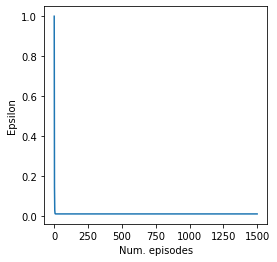

In [24]:
# Define running hyper-parameters and epsilon training sequence
# Feel free to change the parameters
memory_capacity = 200000
# batch_size = 64
batch_size = 64
# num_episodes = 100
num_episodes = 1500
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 1
gamma = 1
lr = 5e-4
hidden_dim_1 = 64
hidden_dim_2 = 64
freq_sync = 10
seed_value = 42

epsilon_by_step = lambda ep_idx: epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * ep_idx / epsilon_decay)

# Plotting out epsilon over episodes that should match what you expect
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot([epsilon_by_step(i) for i in range(num_episodes)])
ax.set_xlabel("Num. episodes")
ax.set_ylabel("Epsilon")

#TODO: Please Ignore this ---------------------------------------------------------------

#ENDTODO --------------------------------------------------------------------------------

### Main Loop and Replay Buffer Control

This is the main loop of our DQN implementation. Here we generate the samples added to the replay memory and train the agent using a batch sampled for the replay memory

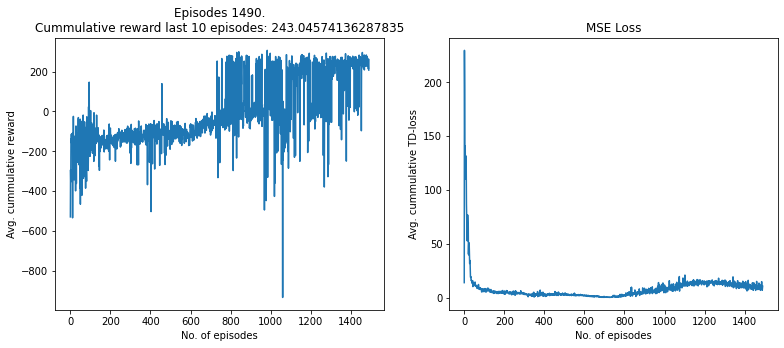

100%|██████████| 1500/1500 [56:18<00:00,  2.25s/it]


In [25]:
losses_list, rewards_list, episode_len_list = [], [], []
list_epsilon = []
replay_buffer = ReplayMemory(memory_capacity)

env = gym.make("LunarLander-v2")
set_seed(env, seed_value)
n_actions = env.action_space.n
dim_state = env.observation_space.shape[0]

agent = DQNAgent(input_dim=dim_state, 
                 output_dim=n_actions, 
                 hidden_dim_1=hidden_dim_1, 
                 hidden_dim_2=hidden_dim_2, 
                 gamma=gamma, lr=lr)

cur_epsilon = epsilon_start


for i_episode in tqdm(range(num_episodes)):

    state, is_finished, ep_len, losses, rewards = env.reset()[0], False, 0, 0, 0

    cur_epsilon = epsilon_by_step(i_episode+1)
    list_epsilon += [cur_epsilon]
    while not is_finished:
        ep_len += 1
        action = agent.obtain_action(state, n_actions, cur_epsilon)
        next_state, reward, done, truncated, _ = env.step(action.item())
        is_finished = done or truncated
        rewards += reward

        t_s = torch.tensor(state).float().to(device)
        t_r = torch.tensor([reward]).float().to(device)
        t_ns = torch.tensor(next_state).float().to(device)
        t_a = action.to(device)
        t_done = torch.tensor([is_finished]).bool().to(device)

        replay_buffer.push(t_s, t_a, t_ns, t_r, t_done)
        state = next_state

        if len(replay_buffer) > batch_size:
            transitions = replay_buffer.sample(batch_size)
            batch = Transition(*zip(*transitions))
            loss = agent.optimize(batch)
            losses += loss

    losses_list.append(losses / ep_len)
    rewards_list.append(rewards)
    episode_len_list.append(ep_len)

    # Add rule that call transfer_parameters() every freq_sync episodes
    if i_episode % freq_sync == 0:
        agent.transfer_parameters()

    # Every 10 episodes we plot the approximator's progress and performance
    if i_episode % 10 == 0:
        plot_ep(i_episode, rewards_list, losses_list)

In [26]:
# save the trained network, this is what you will submit along with your ipynb
file_name = 'Practical08_Exercise.pt' # replace 12345 with your student ID
agent.seed = seed_value
torch.save(agent, file_name)

# Grading

You will be graded based on the performance of your network. Your solution will be executed for a total of 100 trials and the average return will be used to determine your grade. The grading scale is:

| Avg. Return | Marks       |
| ----------- | ----------- |
| < 0         | 1  pt       |
| [0,50)      | 2  pts      |
| [50, 100)   | 3  pts      |
| [100, 150)  | 4  pts      |
| [150, 200)  | 5  pts      |
| ≥ 200       | 6  pts      |

Here is the exact grading procedure: 
- We will grade the performance of the `.pt` file, so we will run `Practical08_Exercise_Grading.ipynb` notebook in the grader (not the `.ipynb` you submitted), obtain `mean_return`, and just compare its value against the table above, feel free to run `Practical08_Exercise_Grading.ipynb` to test your `.pt` file.
- We will NOT run your `.ipynb`, instead, we will inspect it manually to see if there is some malicious behaviour!

# For your submission:
- Submit both a copy of THIS notebook and the trained network following the naming convention (*StudentID_Practical08.ipynb* and *Practical08_Exercise.pt*)
- You can tune the hyper-parameters if needed or modify the architecture of the DQN approximator (don't change the name of the class).
- If you make changes to the architecture if the `DQN` class, please only make changes inside the `nn.Sequential` (if you wish to) because that will get saved in the `.pt` file properly. If you add more things elsewhere in the `DQN` class, there is no guarantee that the grading notebook (`Practical08_Exercise_Grading.ipynb`) will import `.pt` properly and your network might perform differently than what you expected. 
- Also note that different machines and setup might have different randomness in it too, there is no guarantee that the result you get is what you will get on my end, the only way to make sure that I will get the same number is using Deepnote or Binder for cloud and Docker for local install to check your `.pt` file. Meaning you can train the agent in whatever platform you wish to, but you should check your trained `.pt` in Deepnote or Binder for cloud and Docker for local install

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d30c9d78-b335-4e3c-b9dd-5dae33556494' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>